In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

Using TensorFlow backend.


In [2]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

In [4]:
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

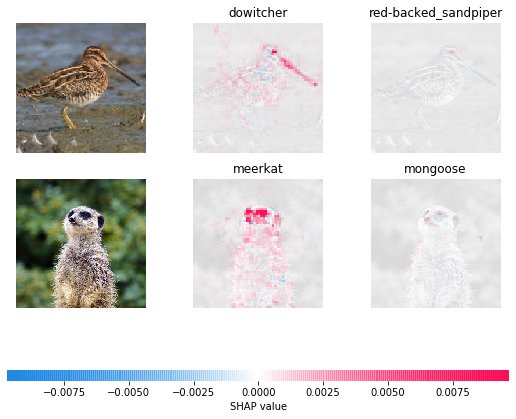

In [5]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. By using ranked_outputs=2 we explain only the two most likely classes for each input (this spares us from explaining all 1,000 classes).